In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120

In [2]:
from houghLines import HoughLines, show_lines, slope_close_to, merge_lines

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from collections import defaultdict

In [158]:
ROI_Y_RATIO = 600/2200
BINARY_THRESHOLD = 200

HOUGH_RHO_RES = 1/4
HOUGH_THETA_RES = np.pi/(4*180)
HOUGH_THRESHOLD = 300
VERTICAL_SLOPE_TOL = 15
RHO_MERGE_TOL = 10/1700

BOX_HEIGHT = 25 # needs to be a ratio (25/2200)
YGAP_BETWEEN_BOXES = 18 # needs to be a ratio (18/2200)
WRITTEN_AVG_INTENSITY_THRESH = 4

MIN_AVG_INTENSITY_SHADED_BOX = 160

In [5]:
def preprocess(img, vertical_edges=False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    blurred_cropped = blurred[int(ROI_Y_RATIO*gray.shape[0]):, :]
    (T, threshinv) = cv2.threshold(blurred_cropped, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY_INV)
    
    if vertical_edges:
        sobel_kernel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]).T
        pf = cv2.filter2D(src=threshinv, ddepth=-1, kernel=sobel_kernel)
        return pf
    return threshinv

In [17]:
def get_vertical_lines(img):
    lines, acc_grid, thetas, rhos = HoughLines(img, HOUGH_RHO_RES, HOUGH_THETA_RES, HOUGH_THRESHOLD)
    sorted_lines = lines[np.argsort(lines[:, 0])]
    vertical_lines = sorted_lines[slope_close_to(sorted_lines[:, 1], 0, tol=VERTICAL_SLOPE_TOL)]
    vertical_lines_merged = vertical_lines[merge_lines(vertical_lines, min_gap=int(RHO_MERGE_TOL*img.shape[1]))]
    return vertical_lines_merged

In [180]:
def patches(img, vertical_lines, stack, sub_stack, col=None):
    y1,y2 = 0,img.shape[0]
    
    if sub_stack == 0:
        x1= 0 if stack==0 else int(vertical_lines[12*stack-1,0])
        x2=int(vertical_lines[12*stack,0])
    elif sub_stack == 1:
        x1=int(vertical_lines[12*stack,0])
        x2=int(vertical_lines[12*stack+2,0])
    else:
        if col is None:
            x1=int(vertical_lines[12*stack+2,0])
            x2=int(vertical_lines[12*stack+11,0])
        else:
            x1=int(vertical_lines[12*stack+2+2*col,0])
            x2=int(vertical_lines[12*stack+2+2*col+1,0])
    
    # print(x1,x2,y1,y2)
    return img[y1:y2, x1:x2]


def connected_components(data):
    labels = np.zeros_like(data).astype(np.uint64)
    n = 0
    for i in range(len(data[1:])):
        left = data[i-1]
        if data[i] != 0:
            if left == 0:
                n += 1
                labels[i] = n
            else:
                labels[i] = n

    return labels


def segment(p, min_width, min_intensity):
    data = np.sum(p, axis=1)/p.shape[1]
    data_thresh = data.copy()
    data_thresh[data_thresh < 20] = 0
    cc = connected_components(data_thresh)

    # remove components with width less than min_width
    labels = set(np.unique(cc))-{0}
    for c in labels:
        if cc[cc == c].shape[0] < min_width:
            cc[cc == c] = 0

    labels = set(np.unique(cc))-{0}

    # calculate average intensity of each component
    avg_intensity = np.zeros(len(labels))
    for i, c in enumerate(labels):
        avg_intensity[i] = np.mean(data_thresh[cc == c])

    # map components with intensity less than min_intensity as 0 (unfilled) otherwise 1 (filled)
    return [1 if i > min_intensity else 0 for i in avg_intensity], cc, avg_intensity

In [157]:
def get_answers(img, vertical_lines):
    answers = defaultdict(list)
    for stack in [0, 1, 2]: # iterating over 3 stacks
        for col in [0, 1, 2, 3, 4]: # iterating over A, B, C, D, E columns
            p = patches(img, vertical_lines, stack=stack, sub_stack=2, col=col)
            qnum_start = 29*stack
            filled, cc, _ = segment(p, min_width=BOX_HEIGHT, min_intensity=MIN_AVG_INTENSITY_SHADED_BOX)  # TODO
            print(stack, col, len(filled))
            for i, f in enumerate(filled):
                if f == 1: # if the box is shaded, f is 1, 0 otherwise
                    q_num = qnum_start + i + 1
                    answers[q_num].append(col)
    return answers

def get_written(img, vertical_lines):
    written = {}
    for stack in [0,1,2]:
        p = patches(img, vertical_lines, stack=stack, sub_stack=0)
        qnum_start = 29*stack
        options_col_p = patches(img, vertical_lines, stack=stack, sub_stack=2, col=0)
        filled, cc, _ = segment(options_col_p, min_width=BOX_HEIGHT, min_intensity=180)

        for i,c in enumerate(set(np.unique(cc))-{0}):
            s=np.nonzero(cc==c)[0] #indexes (y) of pixels from start to end of the box (in vertical direction)
            
            # extend the y boundaries to include half the gap between the boxes, both up and down
            margin = int(Y_GAP_BETWEEN_BOXES/2)
            y1, y2 = s[0]-margin, s[-1]+margin
            
            # reduce the boundaries horizontally to exclude box boudaries that sometimes leak into this patch.
            x1, x2 = 5, -5
            
            avg_intensity = np.mean(p[y1:y2, x1:x2])
            q_num = qnum_start + i + 1
            written[q_num] = avg_intensity > WRITTEN_AVG_INTENSITY_THRESH
    return written

In [84]:
def answer_str(qnum, answers, written):
    return f'{qnum} {"".join([chr(ord("A")+a) for a in answers])}{" x" if written[qnum] else ""}'

def write_to_file(answers, written, output_fname=None):
    answers_str = [answer_str(i, anss, written) for i, anss in sorted(answers.items())]
    
    if output_fname:
        with open(output_fname, 'w') as f:
            f.write('\n'.join(answers_str))
    return answers_str

In [102]:
def compare_answers(groundtruth_file, answers_strs):
    with open('../test-images/a-30_groundtruth.txt') as f:
        groundturth = f.read().split('\n')
    return groundturth == answers_strs

20

In [188]:
img = cv2.imread('../test-images/blank_form.jpg')
img_processed = preprocess(img)
vlines = get_vertical_lines(img_processed)
if vlines.shape[0] != 36:
    raise Exception(f'found {vlines.shape[0]} vertical lines, expecting 36.')

diag 2335.0


In [67]:
answers = get_answers(img_processed, vlines)

0 0 29
0 1 29
0 2 29
0 3 29
0 4 29
1 0 29
1 1 29
1 2 29
1 3 29
1 4 29
2 0 27
2 1 27
2 2 27
2 3 27
2 4 27


In [79]:
written = get_written(img_processed, vlines)

In [88]:
answers_strs = write_to_file(answers, written, 'a-30_results2.txt')

In [159]:
p = patches(img_processed, vlines, stack=2, sub_stack=2, col=3)

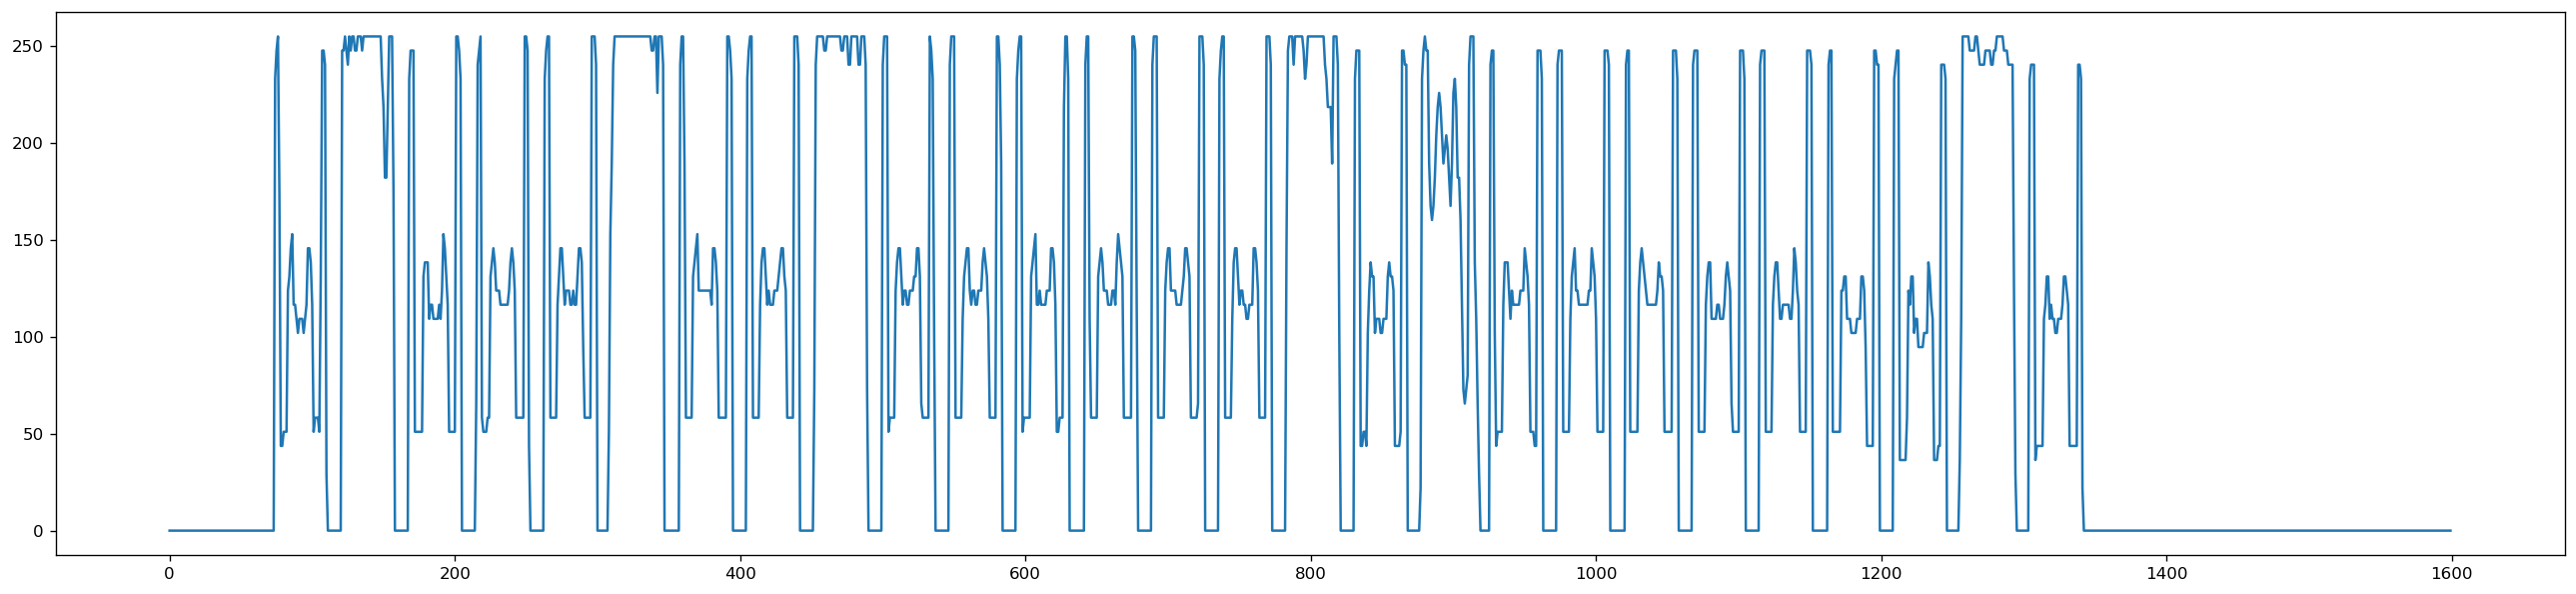

In [160]:
n_clusters=27
plt.figure(figsize=(n_clusters,6))
data = np.sum(p, axis=1)/p.shape[1]
data_thresh = data.copy()
data_thresh[data_thresh<20] = 0
plt.plot(np.arange(len(data_thresh)), data_thresh)

In [185]:
filled, cc, avg_int = segment(p, min_width=BOX_HEIGHT, min_intensity=160)
cc

array([0, 0, 0, ..., 0, 0, 0], dtype=uint64)

In [186]:
filled

[0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0]

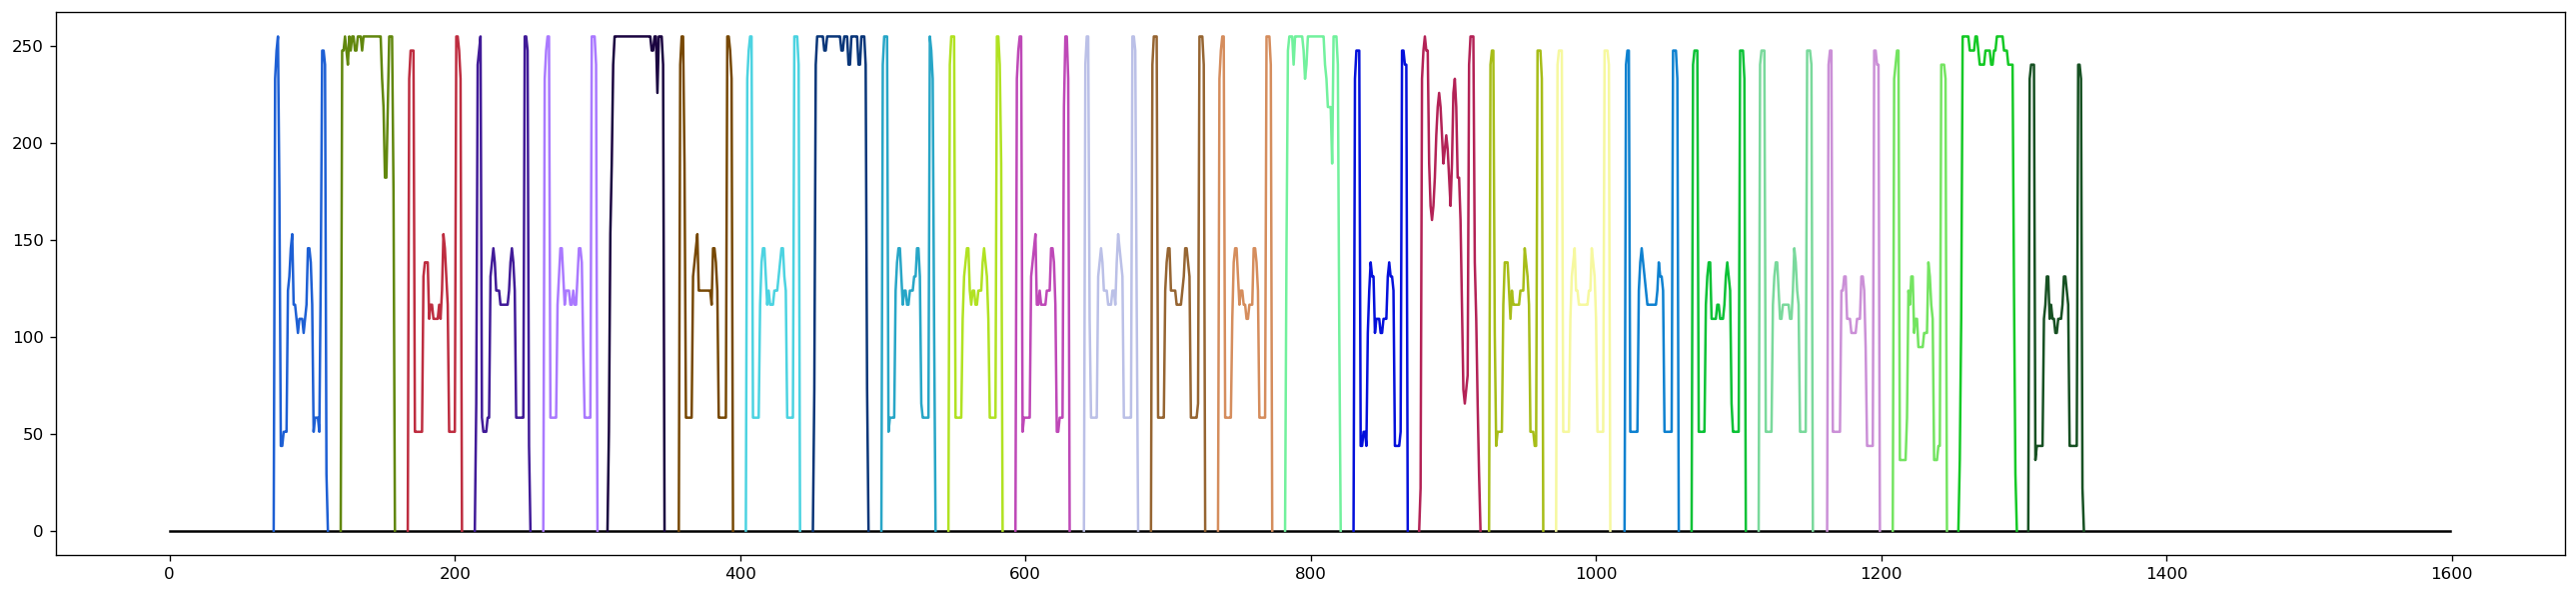

In [177]:
unique_labels = np.unique(cc)
color_map = {l:np.random.choice(range(256), size=3).astype(np.float64)/255 for l in unique_labels} #assign random color to each label
color_map[0] = np.array([0, 0, 0])/255

plt.figure(figsize=(n_clusters,6))
# plt.plot(np.arange(len(data_thresh)), data_thresh, color='black')
for c in np.unique(cc):
    plt.plot(np.where(cc==c)[0], data_thresh[cc==c], color=color_map[c])

In [178]:
labels = set(np.unique(cc))-{0}

# calculate average intensity of each component
avg_intensity = np.zeros(len(labels))
for i, c in enumerate(labels):
    avg_intensity[i] = np.mean(data_thresh[cc == c])

In [179]:
avg_intensity

array([116.01098901, 232.02197802, 121.8021978 , 114.56785714,
       127.78021978, 231.72125436, 126.28571429, 129.08791209,
       230.22857143, 123.67032967, 127.03296703, 125.16483516,
       121.05494505, 127.96703297, 127.40659341, 228.40714286,
       119.37362637, 169.88961039, 119.93406593, 124.04395604,
       117.69230769, 120.49450549, 122.92307692, 112.92857143,
       111.9010989 , 219.78571429, 107.28214286])

(array([ 7., 14.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  5.]),
 array([107.28214286, 119.75612637, 132.23010989, 144.70409341,
        157.17807692, 169.65206044, 182.12604396, 194.60002747,
        207.07401099, 219.54799451, 232.02197802]),
 <BarContainer object of 10 artists>)

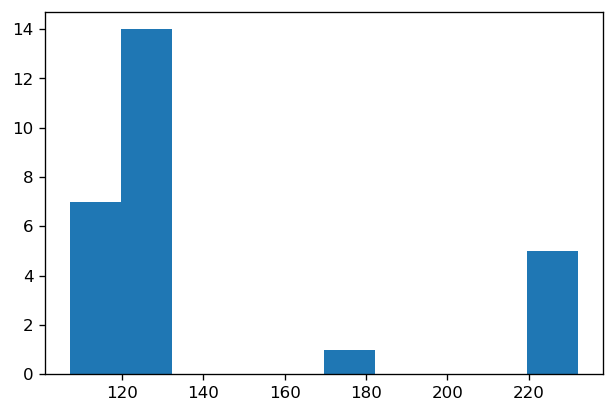

In [166]:
plt.hist(avg_intensity)

In [122]:
from sklearn.cluster import KMeans

In [127]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(avg_intensity.reshape(-1,1))
kmeans.cluster_centers_

array([[129.98972389],
       [240.34350765]])

array([[129.98972389],
       [240.34350765]])

In [133]:
from scipy import ndimage

In [136]:
p = patches(img_processed, vlines, stack=2, sub_stack=2, col=3)
p_dilation = ndimage.binary_dilation(p)
p_closing = ndimage.binary_closing(p)

(array([ 7., 14.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  4.]),
 array([112.92857143, 126.09208494, 139.25559846, 152.41911197,
        165.58262548, 178.746139  , 191.90965251, 205.07316602,
        218.23667954, 231.40019305, 244.56370656]),
 <BarContainer object of 10 artists>)

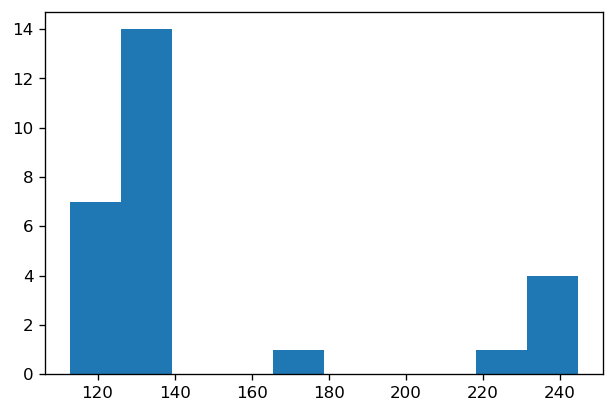

In [156]:
p_new = p#255*p_closing.astype(np.uint8)
filled, cc = segment(p_new, min_width=BOX_HEIGHT, min_intensity=180)
labels = set(np.unique(cc))-{0}

data = np.sum(p_new, axis=1)/p.shape[1]
data_thresh = data.copy()
data_thresh[data_thresh<20] = 0

# calculate average intensity of each component
avg_intensity = np.zeros(len(labels))
for i, c in enumerate(labels):
    avg_intensity[i] = np.mean(data_thresh[cc == c])
    
plt.hist(avg_intensity)

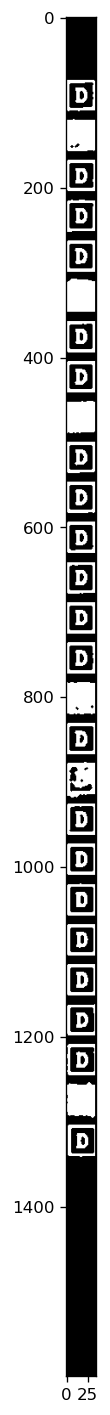

In [137]:
plt.figure(figsize=(15,15))
plt.imshow(p_closing, cmap='gray')

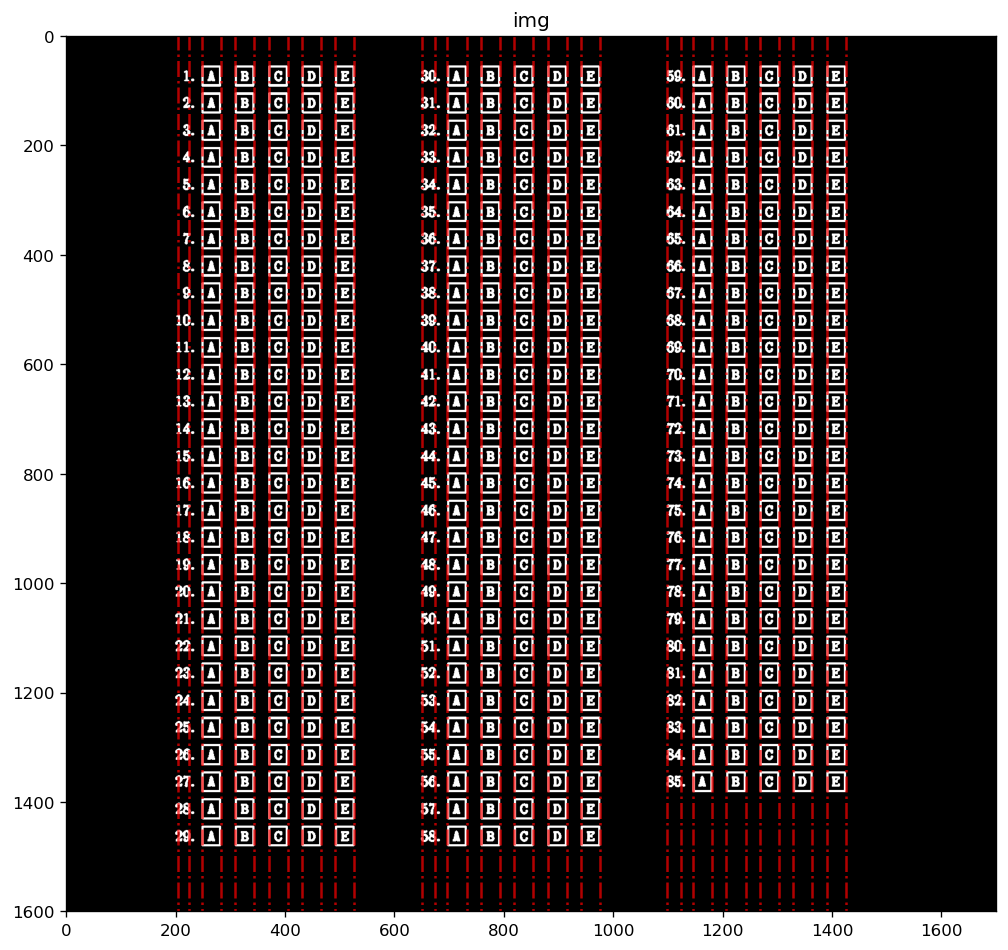

In [189]:
show_lines(img_processed, vlines)